In [5]:
import bayleaf as bf
import numpy as np
import pymc3 as pm
import matplotlib.pylab as plt
%matplotlib inline

# MINIMAL WORKING EXAMPLE

### Simulate Data 

In [2]:
N=500; beta = -0.6; rateC = 0.0001;
maxtime = 200
lam =.11; rho = .6
df_sim = bf.simulate.sim_Weibull(N=N, lam =lam, rho = rho, beta = beta, rateC = rateC, maxtime=maxtime)
df_sim.head()


,time,event,x
0,2.979269,1.0,1.0
1,0.972066,1.0,1.0
2,47.811331,1.0,1.0
3,7.496905,1.0,0.0
4,35.095643,1.0,0.0


(array([ 194.,   76.,   44.,   29.,   21.,   21.,   13.,   14.,    9.,   79.]),
 array([  5.40018459e-03,   2.00048602e+01,   4.00043201e+01,
          6.00037801e+01,   8.00032401e+01,   1.00002700e+02,
          1.20002160e+02,   1.40001620e+02,   1.60001080e+02,
          1.80000540e+02,   2.00000000e+02]),
 <a list of 10 Patch objects>)

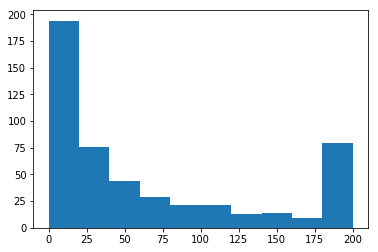

In [6]:
plt.hist(df_sim.time.values)

In [ ]:
### For now, we will work within the pm.Model() environment. We  will embed this at a later date

In [3]:
with pm.Model() as mod:
    bf.ParSurv.from_formula(formula='([time],[event])~x', data=df_sim, family="weibull")
    step = pm.NUTS(target_accept=.99)
    trace = pm.sample(10000,step=step,tune =5000)

100%|██████████| 15000/15000 [02:15<00:00, 110.62it/s]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11c9f1940>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11ce63c88>]], dtype=object)

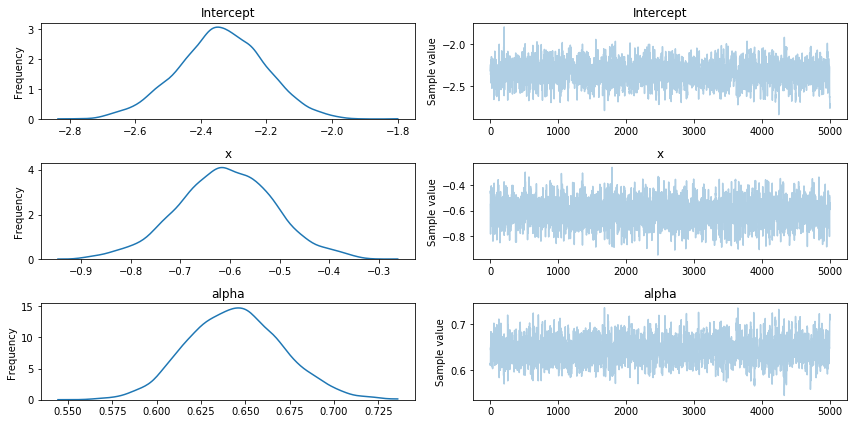

In [4]:
pm.traceplot(trace[5000:])

### Exponentiated intercept corresponds to λ and α = ρ. Need to change this in code 